In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binom
from matplotlib.colors import LinearSegmentedColormap

In [2]:
from abc import ABC, abstractmethod

class RNG(ABC):
    @abstractmethod
    def __init__(self, seed):
        pass
    
    @abstractmethod
    def sample_u64(self):
        pass
    
    @abstractmethod
    def prime_with(self, location_index, time_index):
        pass

In [3]:
class FixedSeaHash(RNG):
    def __init__(self, seed):
        self.seed = np.uint64(seed)
        self.state = np.uint64(seed)
        self.location_index = np.uint64(0)
        self.time_index = np.uint64(0)
    
    def sample_u64(self):
        self.state = FixedSeaHash.diffuse(FixedSeaHash.diffuse(self.state ^ self.location_index) ^ self.time_index) ^ self.seed

        return self.state
    
    def prime_with(self, location_index, time_index):
        self.location_index = np.uint64(location_index)
        self.time_index = np.uint64(time_index)
        
    def diffuse(x):
        x = np.uint64(x) * np.uint64(0x6eed_0e9d_a4d9_4a4f)
        
        a = x >> np.uint64(32)
        b = x >> np.uint64(60)
        
        x = x ^ (a >> b)
        
        return x * np.uint64(0x6eed_0e9d_a4d9_4a4f)

In [4]:
class FixedSeaHash2(RNG):
    def __init__(self, seed):
        self.seed = FixedSeaHash.diffuse(np.uint64(seed) ^ np.uint64(0x16f11fe89b0d677c))
        
        self.a = self.seed
        self.b = np.uint64(0xb480a793d8e6c86c)
        self.c = np.uint64(0x6fe2e5aaf078ebc9)
        self.d = np.uint64(0x14f994a4c5259381)
    
    def sample_u64(self):
        a = FixedSeaHash.diffuse(self.a ^ self.b ^ self.c ^ self.d)
        
        self.a = self.b
        self.b = self.c
        self.c = self.d
        self.d = a
        
        return a
    
    def prime_with(self, location_index, time_index):
        self.a = self.seed
        self.b = FixedSeaHash.diffuse(np.uint64(location_index) ^ np.uint64(0xb480a793d8e6c86c))
        self.c = FixedSeaHash.diffuse(np.uint64(time_index) ^ np.uint64(0x6fe2e5aaf078ebc9))
        self.d = np.uint64(0x14f994a4c5259381)

In [5]:
class FixedSeaHash3(RNG):
    def __init__(self, seed):
        self.seed = np.uint64(seed)
        self.weyl = np.uint64(0)
        
        self.state = self.seed
    
    def sample_u64(self):
        self.weyl += np.uint64(0xb5ad4eceda1ce2a9)
        
        self.state = FixedSeaHash.diffuse(self.state) + self.weyl
        
        return self.state
    
    def prime_with(self, location_index, time_index):
        self.state = FixedSeaHash.diffuse(self.seed ^ location_index) ^ time_index

/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ulong_scalars


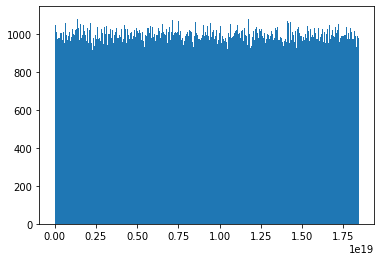

In [6]:
rng = FixedSeaHash(1)

plt.hist([rng.sample_u64() for _ in range(1_000_000)], bins=1000)

plt.show()

/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ulong_scalars


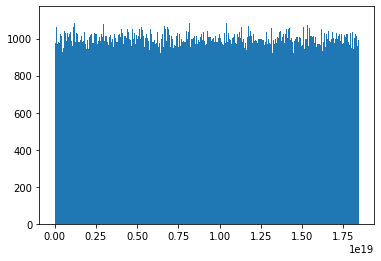

In [7]:
rng = FixedSeaHash2(0x16f11fe89b0d677c)

plt.hist([rng.sample_u64() for _ in range(1_000_000)], bins=1000)

plt.show()

/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in ulong_scalars
  if __name__ == '__main__':
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ulong_scalars
  # This is added back by InteractiveShellApp.init_path()


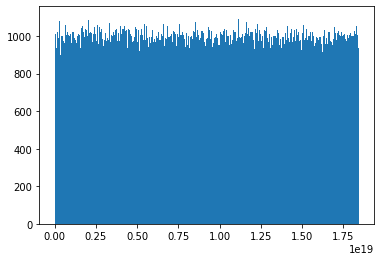

In [8]:
rng = FixedSeaHash3(0)

plt.hist([rng.sample_u64() for _ in range(1_000_000)], bins=1000)

plt.show()

In [9]:
np_rng = np.random.RandomState(
    np.random.MT19937(np.random.SeedSequence(9378470445410382301))
)

integers = np_rng.randint(0, np.iinfo("uint64").max + 1, dtype="uint64", size=1_000_000)
bitflips = np_rng.randint(0, 64, dtype="uint64", size=1_000_000)

fli_ints = integers ^ (np.uint64(0x1) << bitflips)

In [10]:
lookuptable = np.array([bin(i).count('1') for i in range(256)]).astype(np.int32)

def countbits(v):
    assert v.dtype in (np.uint8, np.uint16, np.uint32, np.uint64), 'must be an unsigned int dtype'
    
    return lookuptable[np.reshape(v.view(np.uint8), v.shape + (-1, ))].sum(axis=-1)

np.countbits = countbits

In [11]:
def rhash(x):
    return FixedSeaHash.diffuse(x)

vhash = np.vectorize(rhash)

In [12]:
hash_before = vhash(integers)
hash_after = vhash(fli_ints)

/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in ulong_scalars
/home/ml5717/venv/lib/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [13]:
def hamming(x, y):
    return np.countbits(x ^ y)

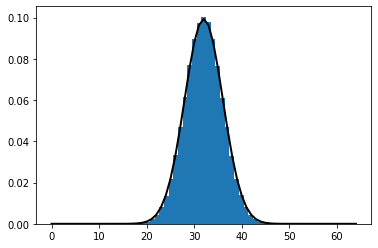

In [14]:
plt.hist(hamming(hash_before, hash_after), range=(0, 64), bins=65, density=True)

x = np.linspace(0, 64, 65)
p = binom.pmf(x, 64, 0.5)
plt.plot(x, p, 'k', linewidth=2)

plt.show()

In [15]:
print(np.mean(hamming(hash_before, hash_after)) / 64)

0.499957609375


In [16]:
bit_dependence = np.zeros(shape=(64, 64), dtype="uint64")
bit_normalisation = np.zeros(shape=(64), dtype="uint64")

for bit, before, after in zip(bitflips, hash_before, hash_after):
    bit_normalisation[bit] += 1
    
    difference = before ^ after
    
    mask = np.uint64(0x1)
    
    for b in range(0, 64):
        if difference & mask:
            bit_dependence[bit, b] += 1
        
        mask <<= np.uint64(1)

In [17]:
avalanche_probability_vector = bit_dependence.sum(axis=0) / integers.size

In [18]:
# Satisfied iff == 64
avalanche_dependence = 64 - np.sum(avalanche_probability_vector == 0.0)
print(avalanche_dependence)

64


In [19]:
# Satisfied iff ~~ 32
avalanche_weight = np.sum(avalanche_probability_vector)
print(avalanche_weight)

31.997287


In [20]:
# Satisfied iff ~~ 64
avalanche_entropy = np.sum(
    -avalanche_probability_vector * np.log2(avalanche_probability_vector)
    -(1.0 - avalanche_probability_vector) * np.log2(1.0 - avalanche_probability_vector)
)
print(avalanche_entropy)

63.99993240559017


In [21]:
""" https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72 """

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [22]:
cmap = get_continuous_cmap(['#000000', '#FF0000'])

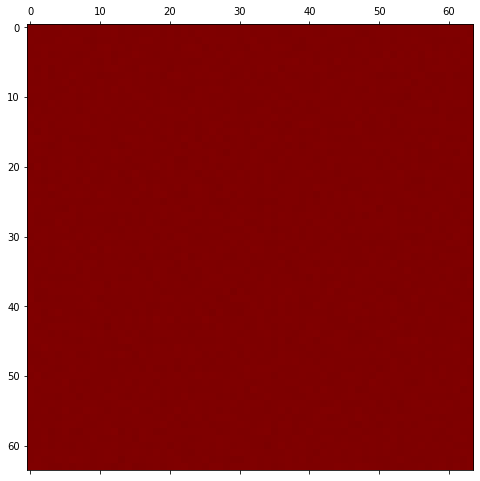

In [23]:
plt.figure(figsize=(8, 8))

plt.matshow(bit_dependence / bit_normalisation.reshape((64, 1)), cmap=cmap, vmin=0.0, vmax=1.0, fignum=1)

plt.show()